# ResNet

In [19]:
#Load necessary libraries
import tensorflow as tf
import numpy as np
import tensorflow.contrib.slim as slim
import input_data
import matplotlib.pyplot as plt
%matplotlib inline

### Load CIFAR Dataset

To obtain the CIFAR10 dataset, go here: https://www.cs.toronto.edu/~kriz/cifar.html

The training data is stored in 5 separate files, and we will alternate between them during training.

In [20]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [21]:
currentCifar = 1
cifar = unpickle('./cifar10/data_batch_1')
cifarT = unpickle('./cifar10/test_batch')

In [22]:
total_layers = 25 #Specify how deep we want our network
units_between_stride = total_layers / 5

## ResNet
An implementation of a Residual Network as described in [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027).

In [23]:
def resUnit(input_layer,i):
    with tf.variable_scope("res_unit"+str(i)):
        part1 = slim.batch_norm(input_layer,activation_fn=None)
        part2 = tf.nn.relu(part1)
        part3 = slim.conv2d(part2,64,[3,3],activation_fn=None)
        part4 = slim.batch_norm(part3,activation_fn=None)
        part5 = tf.nn.relu(part4)
        part6 = slim.conv2d(part5,64,[3,3],activation_fn=None)
        output = input_layer + part6
        return output

tf.reset_default_graph()

input_layer = tf.placeholder(shape=[None,32,32,3],dtype=tf.float32,name='input')
label_layer = tf.placeholder(shape=[None],dtype=tf.int32)
label_oh = slim.layers.one_hot_encoding(label_layer,10)

layer1 = slim.conv2d(input_layer,64,[3,3],normalizer_fn=slim.batch_norm,scope='conv_'+str(0))
for i in range(5):
    for j in range(units_between_stride):
        layer1 = resUnit(layer1,j + (i*units_between_stride))
    layer1 = slim.conv2d(layer1,64,[3,3],stride=[2,2],normalizer_fn=slim.batch_norm,scope='conv_s_'+str(i))
    
top = slim.conv2d(layer1,10,[3,3],normalizer_fn=slim.batch_norm,activation_fn=None,scope='conv_top')

output = slim.layers.softmax(slim.layers.flatten(top))

loss = tf.reduce_mean(-tf.reduce_sum(label_oh * tf.log(output) + 1e-10, axis=[1]))
trainer = tf.train.AdamOptimizer(learning_rate=0.001)
update = trainer.minimize(loss)

### Visualize the network graph
We can call the Tensorflow Board to provide a graphical representation of our network.

In [24]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [25]:
show_graph(tf.get_default_graph().as_graph_def())

## Training

In [29]:
init = tf.global_variables_initializer()
batch_size = 64
currentCifar = 1
total_steps = 20000
l = []
a = []
aT = []
saver = tf.train.Saver()
sess = tf.Session()
sess.run(init)
i = 0
draw = range(10000)
while i < total_steps:
    if i % (10000/batch_size) != 0:
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    else:
        draw = range(10000)
        if currentCifar == 5:
            currentCifar = 1
            print "Switched CIFAR set to " + str(currentCifar)
        else:
            currentCifar = currentCifar + 1
            print "Switched CIFAR set to " + str(currentCifar)
        cifar = unpickle('./cifar10/data_batch_'+str(currentCifar))
        batch_index = np.random.choice(draw,size=batch_size,replace=False)
    x = cifar['data'][batch_index]
    x = np.reshape(x,[batch_size,32,32,3],order='F')
    x = (x/256.0)
    x = (x - np.mean(x,axis=0)) / np.std(x,axis=0)
    y = np.reshape(np.array(cifar['labels'])[batch_index],[batch_size,1])
    _,lossA,yP,LO = sess.run([update,loss,output,label_oh],feed_dict={input_layer:x,label_layer:np.hstack(y)})
    accuracy = np.sum(np.equal(np.hstack(y),np.argmax(yP,1)))/float(len(y))
    l.append(lossA)
    a.append(accuracy)
    if i % 10 == 0: print "Step: " + str(i) + " Loss: " + str(lossA) + " Accuracy: " + str(accuracy)
    if i % 11 == 0: 
        point = np.random.randint(0,10000-500)
        xT = cifarT['data'][point:point+500]
        xT = np.reshape(xT,[500,32,32,3],order='F')
        xT = (xT/256.0)
        xT = (xT - np.mean(xT,axis=0)) / np.std(xT,axis=0)
        yT = np.reshape(np.array(cifarT['labels'])[point:point+500],[500])
        lossT,yP = sess.run([loss,output],feed_dict={input_layer:xT,label_layer:yT})
        accuracy = np.sum(np.equal(yT,np.argmax(yP,1)))/float(len(yT))
        aT.append(accuracy)
        print "Test set accuracy: " + str(accuracy)
    i+= 1
save_path = saver.save(sess, "./trainingmodels/model_resnet.ckpt")
print "Model saved in file: " + str(save_path)
sess.close()

Switched CIFAR set to 2
Step: 0 Loss: 2.74713 Accuracy: 0.125
Test set accuracy: 0.112
Model saved in file: ./trainingmodels/model_resnet.ckpt


KeyboardInterrupt: 

## Results

In [ ]:
plt.plot(l) #Plot training loss

In [ ]:
plt.plot(a) #Plot training accuracy

In [ ]:
plt.plot(aT) #Plot test accuracy

In [ ]:
np.max(aT) #Best test accuracy

Model restored.


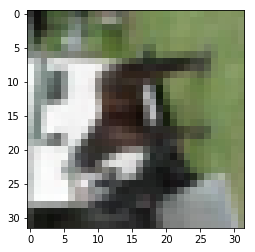

Neural Network predicted: [[ 0.09991998  0.10012002  0.10012002  0.09991998  0.10012002  0.10012002
   0.09991998  0.09992     0.09991999  0.09991999]]
Real label is: [7]


In [32]:
np.seterr(divide='ignore', invalid='ignore')
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./trainingmodels/model_resnet.ckpt")
    print "Model restored."

    num = 1
    imgNum = 20
    imgOrginal = cifarT['data'][imgNum]
    img = np.reshape(imgOrginal,[num,32,32,3],order='F')
    img = (img/256.0)
    img = (img - np.mean(img,axis=0)) / np.std(img,axis=0)
    label = np.reshape(np.array(cifarT['labels'])[imgNum],[num])

    lossT,yP = sess.run([loss,output],feed_dict={input_layer:img,label_layer:label})
    plt.imshow(np.reshape(imgOrginal,(32,32,3), order='F'))
    plt.show()
    
    print 'Neural Network predicted:', np.argmax(yP,1)
    print 'Real label is:', label